# Failures Prediciton
This jupyter notebook describes how to train a ML model for predicting failures of devices in the factory.

#### Download data
The first step is downloading data. We use here a publicly available dataset. Let's download telemetry and failures  csv files.

In [3]:
import os
import urllib.request


REPOSITORY_PATH = "https://github.com/DeeptiChevvuri/Predictive-Maintenance-Modelling-Datasets/raw/master/"
TELEMETRY_FILE_NAME = "telemetry.csv"
FAILURES_FILE_NAME = "failures.csv"
ERRORS_FILE_NAME = "errors.csv"
DATA_FOLDER = "./data"


telemetry_path = os.path.join(DATA_FOLDER, TELEMETRY_FILE_NAME)
failures_path = os.path.join(DATA_FOLDER, FAILURES_FILE_NAME)
errors_path = os.path.join(DATA_FOLDER, ERRORS_FILE_NAME)

os.makedirs(DATA_FOLDER, exist_ok=True)


if not os.path.isfile(telemetry_path):
    urllib.request.urlretrieve(REPOSITORY_PATH + TELEMETRY_FILE_NAME, telemetry_path)
    
if not os.path.isfile(failures_path):
    urllib.request.urlretrieve(REPOSITORY_PATH + FAILURES_FILE_NAME, failures_path)
    
if not os.path.isfile(errors_path):
    urllib.request.urlretrieve(REPOSITORY_PATH + ERRORS_FILE_NAME, errors_path)

#### Read and prepare datasets
Now we are ready to read the datasets into pandas dataframes

In [4]:
import pandas as pd


telemetry_df = pd.read_csv(telemetry_path) 
telemetry_df['datetime'] = pd.to_datetime(telemetry_df['datetime'], format='%m/%d/%Y %I:%M:%S %p')
telemetry_df

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511
...,...,...,...,...,...,...
876095,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941
876096,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072
876097,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561
876098,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259


In real scenarios it's often better to run a separate model for each machine. It might be a separately trained model or just a fine tuned one. In current example scenario we are going to train one model for all machines. However, it's necessary first to ensure that the telemetry values do not differ too much. Box plots are very helpful for checking it.

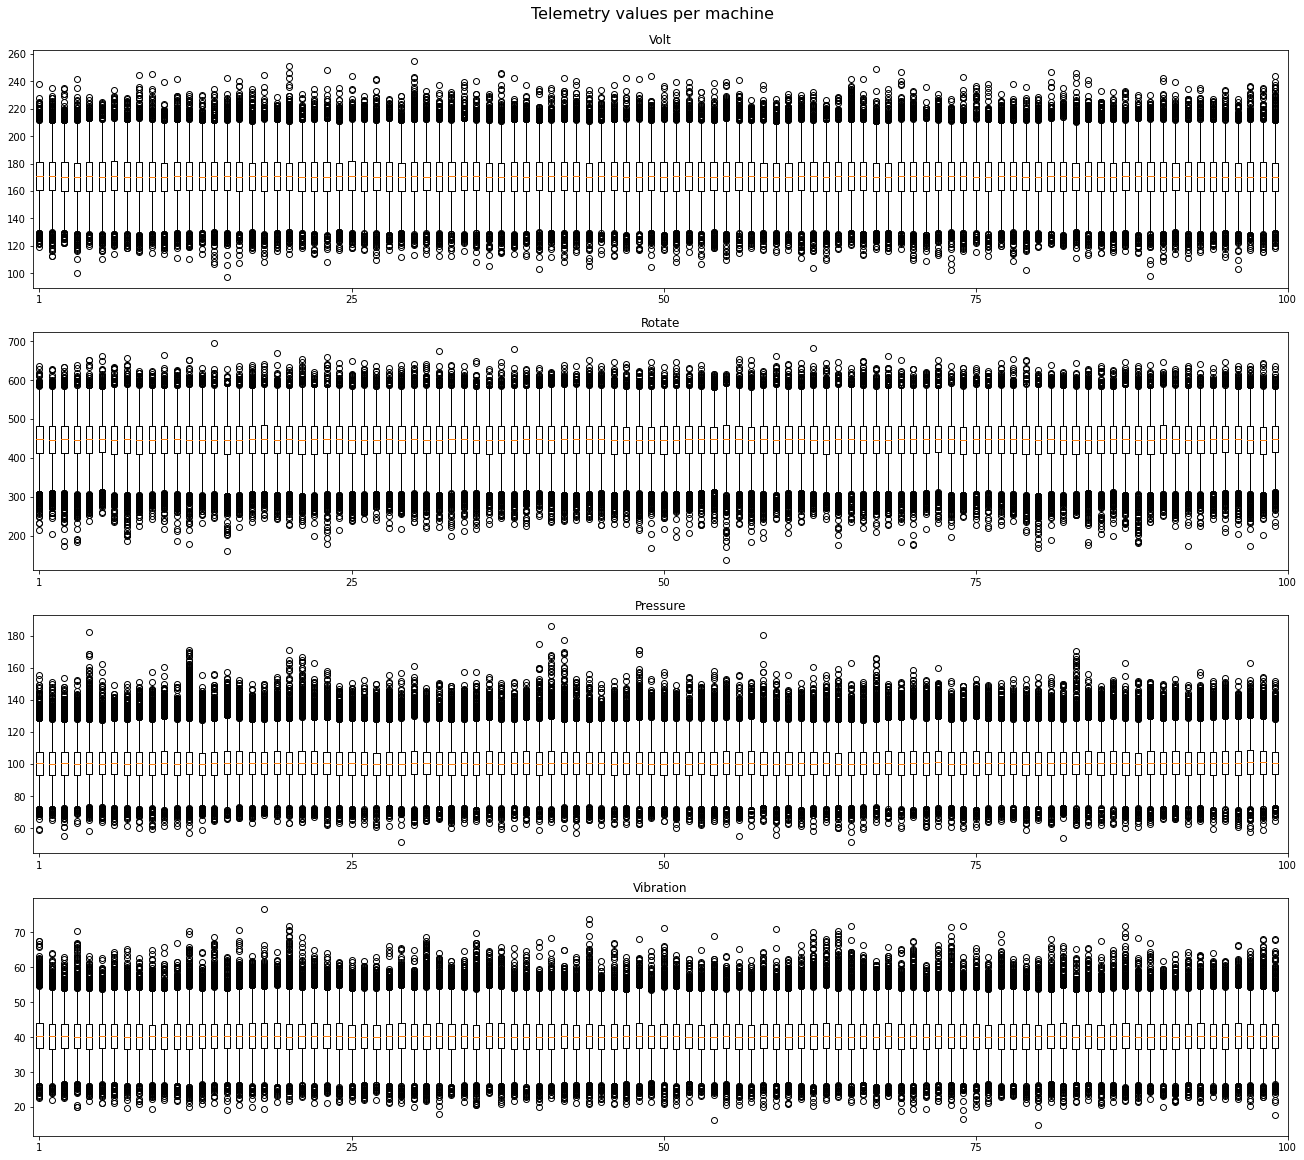

In [5]:
import matplotlib.pyplot as plt
import numpy as np


volt_values = []
rotate_values = []
pressure_values = []
vibration_values = []

for i in range(1,101):
    volt_values.append(telemetry_df[telemetry_df['machineID'] == i]["volt"])
    rotate_values.append(telemetry_df[telemetry_df['machineID'] == i]["rotate"])
    pressure_values.append(telemetry_df[telemetry_df['machineID'] == i]["pressure"])
    vibration_values.append(telemetry_df[telemetry_df['machineID'] == i]["vibration"])

    
fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize=(18, 16))
fig.suptitle('Telemetry values per machine', fontsize=16)


def build_box_plot(plot_index, plot_values, title):
    axs[plot_index].boxplot(plot_values)
    axs[plot_index].set_title(title)
    axs[plot_index].set_xticks([1, 26, 51, 76, 101])
    axs[plot_index].set_xticklabels([1, 25, 50, 75, 100])

    
build_box_plot(0, volt_values, "Volt")
build_box_plot(1, rotate_values, "Rotate")
build_box_plot(2, pressure_values, "Pressure")
build_box_plot(3, vibration_values, "Vibration")
plt.show()

Looking at the boxplots we can see that most of the telemetry values are not very scattered. So we can try training one model for all the devices. 
Now we require to read the failures and errors data and then map it to the telemetry data frame. 

In [6]:
failures_df = pd.read_csv(failures_path) 
failures_df['datetime'] = pd.to_datetime(failures_df['datetime'], format='%m/%d/%Y %I:%M:%S %p')
failures_df

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4
...,...,...,...
756,2015-11-29 06:00:00,99,comp3
757,2015-12-14 06:00:00,99,comp4
758,2015-02-12 06:00:00,100,comp1
759,2015-09-10 06:00:00,100,comp1


In [7]:
errors_df = pd.read_csv(errors_path) 
errors_df['datetime'] = pd.to_datetime(errors_df['datetime'], format='%m/%d/%Y %I:%M:%S %p')
errors_df

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4
...,...,...,...
3914,2015-11-21 08:00:00,100,error2
3915,2015-12-04 02:00:00,100,error1
3916,2015-12-08 06:00:00,100,error2
3917,2015-12-08 06:00:00,100,error3


In [8]:
failures = [False]*len(telemetry_df)
errors = {} 
is_error = [False]*len(telemetry_df)

for error in errors_df.errorID.unique():
    errors[error] = [False]*len(telemetry_df)

for machine_id in telemetry_df.machineID.unique():
    machine_telemetry = telemetry_df[telemetry_df.machineID==machine_id]
    
    for date_time in failures_df[failures_df.machineID == machine_id].datetime:
        for date_time_index in machine_telemetry.index[machine_telemetry.datetime==date_time]:                
            failures[date_time_index] = True
    
    for _, error_row  in errors_df[errors_df.machineID == machine_id].iterrows():
        date_time = error_row.datetime
        error_id = error_row.errorID
        for date_time_index in machine_telemetry.index[machine_telemetry.datetime==date_time]:                
            errors[error_id][date_time_index] = True
            is_error[date_time_index] = True


telemetry_df['failures'] = failures
telemetry_df['is_error'] = is_error

for error_col_key in errors.keys():
    telemetry_df[error_col_key] = errors[error_col_key]
    
print(sum(telemetry_df.failures))
print(sum([sum(telemetry_df[e]) for e in errors.keys()]))

719
3919


In total there are less failures than rows in the failure table. The reason is that this table contains data on component level. Sometimes more than one component fails at the same time. We are more interested in total machine failures, thus ignoring too granular components information.
Now we can look into the telemetry value and compare them with normal. This way we can analyze if there is any stright forward depdendency between telemetry values and failures. To do this, let's build two scatter plots. 

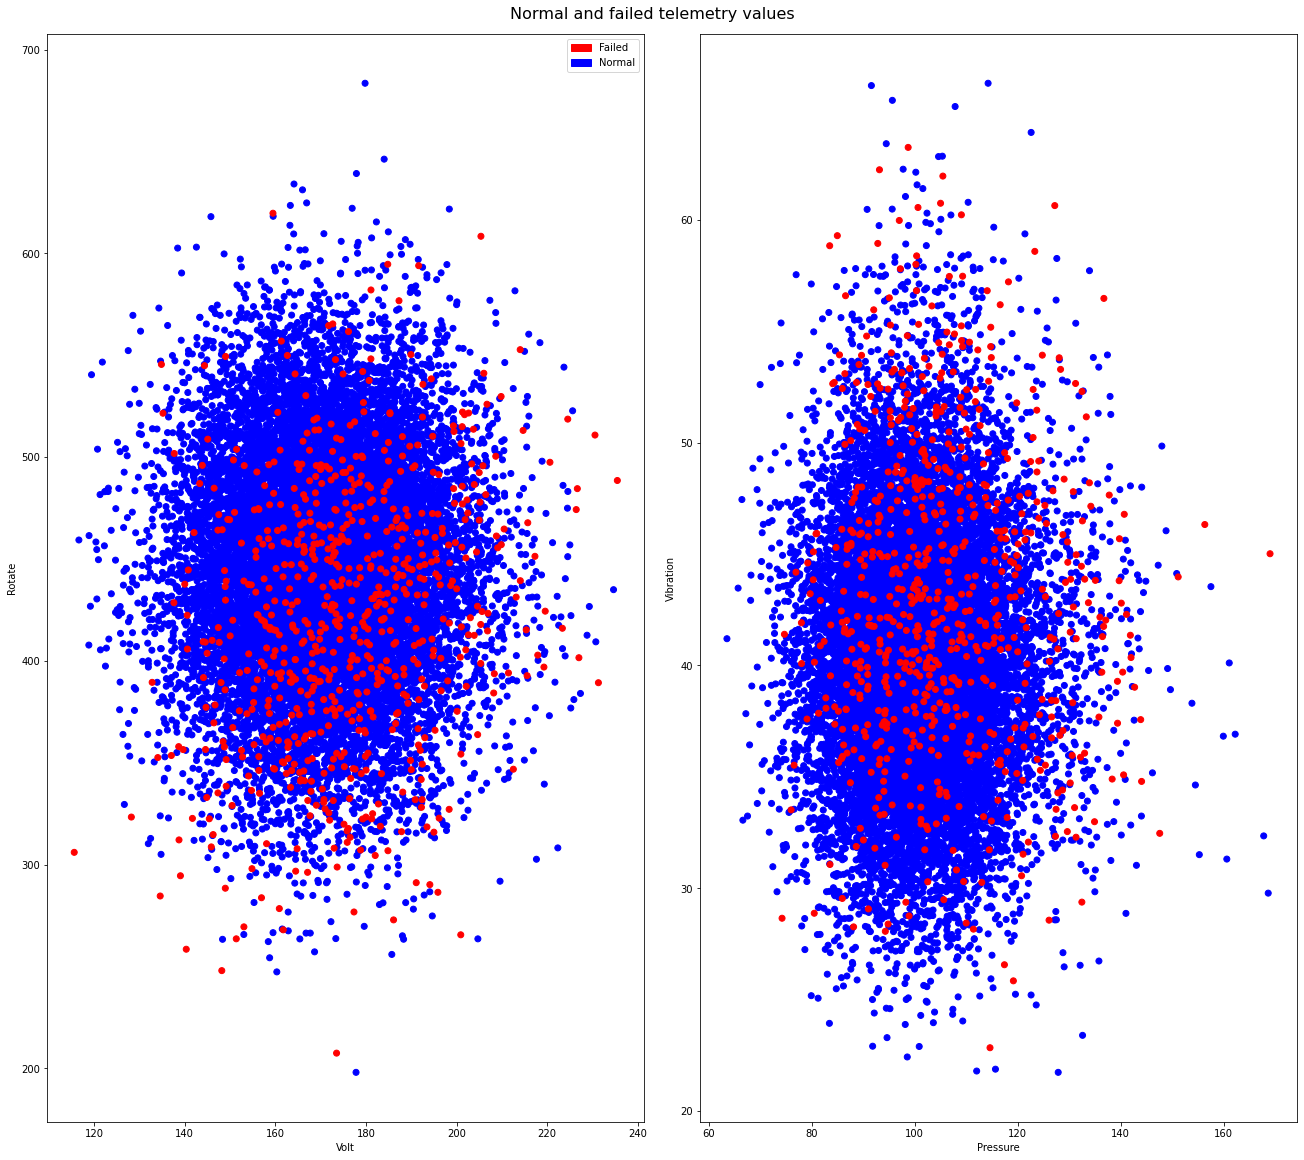

In [9]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


colors = {True: "r", False: "b"}
tel_subsample_df = telemetry_df[telemetry_df.failures==False].sample(frac=0.02)
tel_subsample_df = pd.concat([tel_subsample_df, telemetry_df[telemetry_df.failures==True]])

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(18, 16))
fig.suptitle('Normal and failed telemetry values', fontsize=16)
axs[0].legend(handles=[mpatches.Patch(color='r', label='Failed'), mpatches.Patch(color='b', label='Normal')])
axs[0].set_xlabel('Volt')
axs[0].set_ylabel('Rotate')
axs[0].scatter(tel_subsample_df.volt, tel_subsample_df.rotate, color=tel_subsample_df.failures.map(colors))
axs[1].set_xlabel('Pressure')
axs[1].set_ylabel('Vibration')
axs[1].scatter(tel_subsample_df.pressure, tel_subsample_df.vibration, color=tel_subsample_df.failures.map(colors))
pass

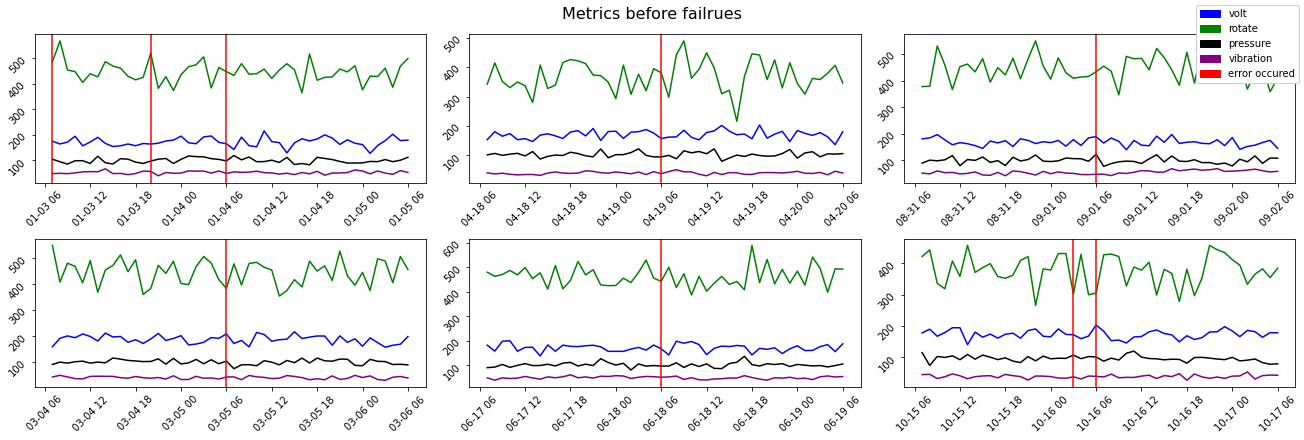

In [10]:
failure_indexes = telemetry_df.index[telemetry_df['failures']]
tel_shift = 48

colors = [mpatches.Patch(color='blue', label='volt'), 
          mpatches.Patch(color='green', label='rotate'), 
          mpatches.Patch(color='black', label='pressure'),           
          mpatches.Patch(color='purple', label='vibration'),
          mpatches.Patch(color='red', label='error occured')]


fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize=(18, 6))
fig.suptitle('Metrics before failrues', fontsize=16)
fig.legend(handles=colors, facecolor='white', framealpha=1)

def build_plot(row, column, series_df):
    axs[row, column].plot(series_df.datetime, series_df.volt, color='blue')
    axs[row, column].plot(series_df.datetime, series_df.rotate, color='green')
    axs[row, column].plot(series_df.datetime, series_df.pressure, color='black')
    axs[row, column].plot(series_df.datetime, series_df.vibration, color='purple')
    axs[row, column].tick_params(labelrotation=45)

    for _, series_row  in series_df.iterrows():
        if series_row.is_error:
            axs[row, column].axvline(x=series_row.datetime, color='red')


for i in range(6):
    f_index = failure_indexes[i]
    failure_series_df = telemetry_df.iloc[(f_index - tel_shift + 1):(f_index + 1)]    
    row = i % 2
    column = i // 2
    build_plot(row, column, failure_series_df)

The charts above illustrate what is happening with a machine before a failure. Red vertical lines show the moments when errors occure. Charts show that errors tend to occure before the failures and can be a good predictor. The telemetry values are not so obvious and it's hard to find visual patterns in them.

In [11]:
telemetry_df

,datetime,machineID,volt,rotate,pressure,vibration,failures,is_error,error1,error3,error5,error4,error2
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,False,False,False,False,False,False,False
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,False,False,False,False,False,False,False
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,False,False,False,False,False,False,False
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,False,False,False,False,False,False,False
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
876095,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,False,False,False,False,False,False,False
876096,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,False,False,False,False,False,False,False
876097,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,False,False,False,False,False,False,False
876098,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,False,False,False,False,False,False,False


In [35]:
len(failure_indexes)

719

In [41]:
hours_ahead = 12
hours_lag = 36
tel_columns = ["volt", "rotate", "pressure", "vibration"]
error_columns = ["error1", "error2", "error3", "error4", "error5"]

col_names = []
for tel_c in tel_columns:
    col_names.extend([tel_c + "_min", tel_c + "_max", tel_c + "_std", tel_c + "_mean"])

for err_c in error_columns:
    col_names.append(err_c + "_sum")


def get_time_span_statistics(source_df, lag_start, lag_end):
    lag_values_df = source_df.iloc[lag_start:lag_end]
    failure_record = []

    for col_name in tel_columns:
        failure_record.extend([lag_values_df[col_name].min(), 
                               lag_values_df[col_name].max(), 
                               lag_values_df[col_name].std(), 
                               lag_values_df[col_name].mean()])

    for col_name in error_columns:
        failure_record.append(lag_values_df[col_name].sum())
    
    return failure_record


failure_records = []
failure_ranges = []

for f_index in failure_indexes:
    start_i = f_index - hours_ahead - hours_lag
    end_i = f_index - hours_ahead
    
    failure_ranges.extend(np.arange(f_index - hours_ahead - hours_lag, f_index + hours_ahead + hours_lag))
    failure_records.append(get_time_span_statistics(telemetry_df, start_i, end_i))

failure_records_df = pd.DataFrame(failure_records)
failure_records_df.columns = col_names
failure_records_df['is_error'] = True
failure_records_df

,volt_min,volt_max,volt_std,volt_mean,rotate_min,rotate_max,rotate_std,rotate_mean,pressure_min,pressure_max,...,vibration_min,vibration_max,vibration_std,vibration_mean,error1_sum,error2_sum,error3_sum,error4_sum,error5_sum,is_error
0,129.016707,215.656488,16.526837,171.335525,365.213804,568.972310,42.008244,450.361078,82.400818,118.853452,...,39.273567,66.764515,5.277719,51.774580,1,0,1,0,1,True
1,158.476091,216.930340,15.221874,189.627641,354.540120,549.924403,49.173814,444.347733,74.378060,115.764539,...,32.146059,49.029715,4.887823,40.476386,1,0,0,0,0,True
2,146.821322,201.731995,13.785538,171.413036,215.619476,489.502527,54.922459,363.913329,79.552597,121.827141,...,30.093808,50.877634,4.546094,39.263971,0,1,1,0,0,True
3,138.300867,200.092776,15.656864,173.345692,387.342414,581.811206,40.169602,459.948724,80.630055,136.553131,...,38.751573,61.150030,5.433657,49.512631,0,0,0,0,1,True
4,138.740244,207.324122,15.219219,170.153989,345.711420,549.741973,46.975781,444.673658,75.959631,121.728619,...,40.510669,67.409029,6.092420,51.432075,0,0,0,0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714,145.603331,212.136267,14.325939,170.203287,318.872099,561.052384,51.810797,449.063938,104.241822,154.095588,...,30.749250,54.708004,4.802154,40.358716,0,0,0,1,0,True
715,137.312574,195.589093,13.070156,169.364467,259.096573,488.047354,57.253621,373.551439,80.389208,142.017146,...,39.429014,60.587742,4.804673,49.493438,0,0,0,0,1,True
716,164.312193,224.864627,14.536794,190.509271,379.354036,551.408571,48.437351,453.582009,84.148316,134.365456,...,26.609883,54.567871,5.522002,39.876128,1,0,0,0,0,True
717,163.476447,229.249877,13.718246,193.127389,325.420678,548.251346,48.218963,456.922911,85.577543,118.707002,...,31.921128,53.508080,4.818453,40.791658,1,0,0,0,0,True


In [65]:
normal_functioning_records = []
normal_functioning_indexes = telemetry_df.drop(failure_ranges).sample(20000).index

for n_index in normal_functioning_indexes:        
    start_i = n_index - hours_ahead - hours_lag
    end_i = n_index - hours_ahead
    normal_functioning_records.append(get_time_span_statistics(telemetry_df, start_i, end_i))

normal_functioning_records_df = pd.DataFrame(normal_functioning_records)
normal_functioning_records_df.columns = col_names
normal_functioning_records_df['is_error'] = False
normal_functioning_records_df

,volt_min,volt_max,volt_std,volt_mean,rotate_min,rotate_max,rotate_std,rotate_mean,pressure_min,pressure_max,...,vibration_min,vibration_max,vibration_std,vibration_mean,error1_sum,error2_sum,error3_sum,error4_sum,error5_sum,is_error
0,138.743982,203.510679,15.552915,170.474519,391.972605,602.423021,47.656649,458.049137,85.210225,125.382545,...,31.212730,54.735561,5.826152,39.946476,0,0,0,0,0,False
1,120.304512,197.656588,17.806568,171.171854,329.580125,600.682307,54.584517,447.780338,77.861934,118.416973,...,30.259298,53.170160,5.353241,41.144244,0,0,0,0,0,False
2,138.903968,185.619152,11.125496,168.671294,351.350419,591.002839,49.208586,450.435421,76.604707,119.021125,...,32.141699,54.810437,5.478673,41.563051,0,0,0,1,0,False
3,128.855157,198.208653,15.344640,172.526323,359.660733,537.167096,49.585073,446.956764,77.125226,112.324144,...,29.927305,48.742046,5.450792,39.036759,0,1,0,0,0,False
4,140.053501,191.309548,13.146585,167.441981,308.111969,522.005428,49.429938,434.329794,74.543589,127.026842,...,32.125997,50.718934,5.595522,40.662548,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,141.156144,200.245215,13.793430,173.163205,341.282840,577.795339,53.911934,454.592248,80.648936,120.459634,...,29.483479,47.521798,4.430862,39.737769,0,0,0,0,0,False
19996,139.648677,201.269389,14.607280,170.302486,355.088237,596.189015,59.911204,443.693819,83.526103,124.578002,...,31.937354,55.508059,4.844798,40.976464,0,0,0,0,0,False
19997,142.090651,193.334639,12.775181,168.668125,340.104191,578.507197,52.315148,459.534490,83.049876,151.926308,...,27.851099,57.036380,7.147214,42.305372,0,0,0,0,0,False
19998,134.299144,187.411438,11.913171,168.603772,330.111053,517.878188,44.783501,442.660965,80.025392,118.575902,...,28.519656,48.753311,4.346063,39.550650,0,0,0,0,0,False


In [67]:
combined_df = pd.concat([failure_records_df, normal_functioning_records_df], ignore_index=True)
combined_df = combined_df.sample(len(combined_df))
combined_df

,volt_min,volt_max,volt_std,volt_mean,rotate_min,rotate_max,rotate_std,rotate_mean,pressure_min,pressure_max,...,vibration_min,vibration_max,vibration_std,vibration_mean,error1_sum,error2_sum,error3_sum,error4_sum,error5_sum,is_error
19500,148.603324,222.982069,15.522910,190.589060,368.370953,591.533100,55.248733,460.018198,78.331242,126.622955,...,25.977942,50.492809,4.745668,40.125801,0,0,0,0,0,False
18085,147.471987,228.820276,18.308172,184.019824,353.557956,515.949050,42.675510,437.949702,85.218096,121.113151,...,28.902059,51.873254,5.396800,39.829002,0,0,0,0,0,False
9236,143.083914,200.466440,11.856787,168.352782,288.961848,594.849120,61.411119,440.238525,72.943328,119.234619,...,30.869141,49.148255,4.994415,41.189992,0,0,0,0,0,False
11133,142.061771,192.333864,14.707752,168.582389,363.635584,553.572639,55.141792,457.782535,79.066466,118.463293,...,30.970280,50.993296,5.009510,40.470461,0,0,0,0,0,False
3610,130.909871,207.036865,17.909030,167.526043,351.053037,543.333109,44.211775,451.629960,76.308998,121.706037,...,31.497975,48.578906,3.975367,40.337168,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14491,130.107439,196.040628,14.993116,164.707165,373.069195,564.788789,52.654166,455.437665,84.363437,119.188875,...,27.219673,50.144753,5.340458,38.114217,0,0,0,0,0,False
6436,126.428858,194.734089,13.256071,165.824039,321.219928,540.082326,55.331029,442.718189,81.963645,120.264030,...,30.372620,50.585996,5.122870,40.036620,0,0,0,0,0,False
16806,139.736525,203.462078,14.174872,167.804265,346.117332,539.917097,41.391544,446.898462,82.752415,131.983494,...,31.318737,54.250949,5.690485,41.015690,0,0,0,0,0,False
3989,142.032456,209.508460,17.930268,178.325590,291.031333,569.877214,64.615089,431.185699,79.984348,132.353177,...,26.297721,50.477093,5.816756,40.186295,0,0,0,0,0,False


In [79]:
split_mask = np.random.rand(len(combined_df)) < 0.7

x_df = combined_df.drop(['is_error'], axis=1)
y_df = combined_df['is_error']

x_train = x_df[split_mask]
y_train = y_df[split_mask]

x_test_validation = x_df[~split_mask]
y_test_validation = y_df[~split_mask]

split_mask = np.random.rand(len(x_test_validation)) < 0.5
x_validation = x_test_validation[split_mask]
y_validation = y_test_validation[split_mask]

x_test = x_test_validation[~split_mask]
y_test = y_test_validation[~split_mask]

print("Number of failure items in training set %d" % sum(y_train))
print("Number of failure items in validation set %d" % sum(y_validation))
print("Number of failure items in test set %d" % sum(y_test))

Number of failure items in training set 531
Number of failure items in validation set 91
Number of failure items in test set 97


In [85]:
from xgboost import XGBRegressor, XGBClassifier


model = XGBClassifier(max_depth=10, n_estimators=100, seed=0)
model.fit(
    x_train, 
    y_train, 
    eval_set=[(x_validation, y_validation)], 
    early_stopping_rounds=10, 
    eval_metric="aucpr"
)

[0]	validation_0-aucpr:0.97447
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.97529
[2]	validation_0-aucpr:0.98186
[3]	validation_0-aucpr:0.98143
[4]	validation_0-aucpr:0.98097
[5]	validation_0-aucpr:0.98167
[6]	validation_0-aucpr:0.98080
[7]	validation_0-aucpr:0.98088
[8]	validation_0-aucpr:0.98052
[9]	validation_0-aucpr:0.98034
[10]	validation_0-aucpr:0.98409
[11]	validation_0-aucpr:0.98532
[12]	validation_0-aucpr:0.98531
[13]	validation_0-aucpr:0.98535
[14]	validation_0-aucpr:0.98645
[15]	validation_0-aucpr:0.98646
[16]	validation_0-aucpr:0.98642
[17]	validation_0-aucpr:0.98661
[18]	validation_0-aucpr:0.98685
[19]	validation_0-aucpr:0.98704
[20]	validation_0-aucpr:0.98666
[21]	validation_0-aucpr:0.98668
[22]	validation_0-aucpr:0.98712
[23]	validation_0-aucpr:0.98680
[24]	validation_0-aucpr:0.98659
[25]	validation_0-aucpr:0.98671
[26]	validation_0-aucpr:0.98634
[27]	validation_0-aucpr:0.98615
[28]	validation_0-aucpr:0.98735
[29]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [93]:
from sklearn import metrics


test_predictions = model.predict(x_test)
metrics.precision_recall_fscore_support(y_test, test_predictions)

(array([0.99866221, 0.9893617 ]),
 array([0.99966522, 0.95876289]),
 array([0.99916346, 0.97382199]),
 array([2987,   97]))

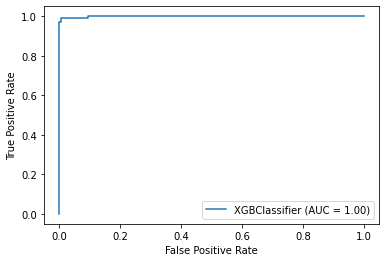

In [94]:
metrics.plot_roc_curve(model, x_test, y_test)